---

# For reviewers, please follow the notebook using `nbviewer`

# (copypaste the full github URL of this notebook in [http://nbviewer.jupyter.org/](http://nbviewer.jupyter.org/))

---

# HW5 ADA - Text taming

Table of contents : 
    1. About word clouds
        1.1. Using raw corpus
        1.2. Using NLP processed data
    2. About Sentiment Analysis
        2.1. Getting e-mails that talk about countries
        2.2. Visualization
    3. Topic Extraction
        3.1. Manual judgement

In [64]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

# 1 - About word clouds

> Generate a word cloud based on the raw corpus -- I recommend you to use the Python word_cloud library. With the help of nltk (already available in your Anaconda environment), implement a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and cons (if any) of the two word clouds you generated.

In [2]:
from wordcloud import WordCloud

## 1.1 - Using the raw corpus

We want to use the email contents to do a wordcloud of it. But no pre-processing on the words should be done. We just  use the columns `ExtractedSubject` and `ExtractedBodyText`. Let's import the data as strings and clean it.

In [3]:
data = pd.read_csv("hillary-clinton-emails/Emails.csv", index_col=0)
data = data[["ExtractedSubject", "ExtractedBodyText"]]
data = data.astype(str)
data = data.replace(to_replace="nan", value=" ")

In [4]:
data.head()

,ExtractedSubject,ExtractedBodyText
Id,,
1,FW: Wow,
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
3,Re: Chris Stevens,Thx
4,FVV: Cairo Condemnation - Final,
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


We concatenate the two first columns to get the final raw text column `Raw`

In [5]:
data["Raw"] = data.ExtractedSubject.str.cat(data.ExtractedBodyText, sep=" ")

In [6]:
data.head()

,ExtractedSubject,ExtractedBodyText,Raw
Id,,,
1,FW: Wow,,FW: Wow
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","B6\nThursday, March 3, 2011 9:45 PM\nH: Late..."
3,Re: Chris Stevens,Thx,Re: Chris Stevens Thx
4,FVV: Cairo Condemnation - Final,,FVV: Cairo Condemnation - Final
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","H <hrod17@clintonemail.com>\nFriday, March 1..."


Let's concatenate all the values now using the `join()` method.

In [7]:
text = " ".join(data.Raw.values)

We can already use the wordcloud library, making sure no NLP pre-processing is done by specifying `stopwords=[]` and we make it fancy with a US eagle mask!

In [8]:
from PIL import Image
mask = np.array(Image.open("mask.png"))

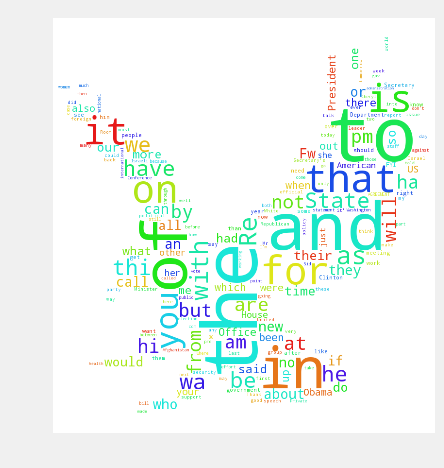

In [9]:
wordcloud = WordCloud(stopwords=[], background_color="white", mask=mask).generate(text)  # generate a word cloud image
plt.figure(figsize=(5,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This first wordcloud, by default, displays word sizes proportionally to frequency, which prevents from seeing a lot of them. Let's first adjust this using `max_font_size=40`

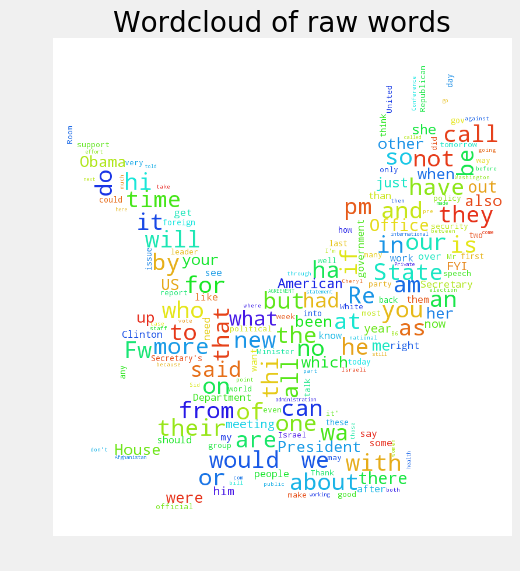

In [10]:
wordcloud = WordCloud(max_font_size=40, stopwords=[], background_color="white", mask=mask).generate(text)
plt.figure(figsize=(6,6))
plt.title("Wordcloud of raw words")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Now, besides the display issues, we must acknowledge that most words __don't bring any information__ such as the, oh, in, and, he, are etc... Indeed, this is very typical of the Zipf's law, clearly observable when plotting word frequencies below :

#### Zipf's law

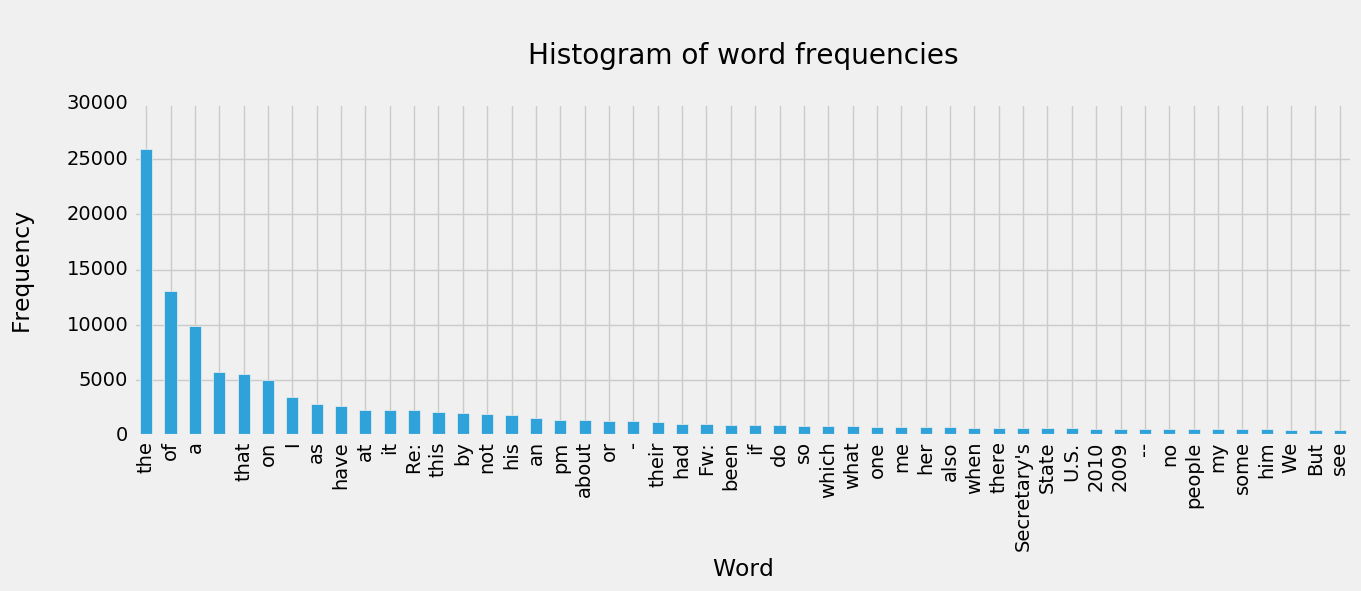

In [11]:
pd.DataFrame(data=" ".join(data.Raw).split(" ")).apply(pd.value_counts)[:100:2].plot(
    kind='bar', title="\nHistogram of word frequencies\n", legend=False, figsize=(14,4));
plt.ylabel("Frequency\n")
plt.xlabel("Word")
plt.xticks(rotation=90);

We can indeed see that the distribution of word frequencies has a real exponential decrease because some words have a very high frequency but give no meaning (ex: stop words).

Something else can be discovered when checking this distribution, but this time looking at the tail. 

In [12]:
pd.Series(data=" ".join(data.Raw).split(" ")).value_counts()[:-10:-1]

Comments\nAlec          1
House\n1:00             1
tumult                  1
Six-Party               1
cabinet',               1
readership,             1
parts.                  1
that\n2005              1
Taleban.\nFrightened    1
dtype: int64

Indeed, without cleaning the texts, there are some punctuations, \n or noise things that really prevent to get a good tokenization and insight on what is being said on the e-mails.  

So now we really need to do some NLP processing to our text!

## 1.2 - Using NLP tools to pre-process

We want to pre-process these data with Natural Language Processing, having the **bag of words** approach : texts are actually only sets of words, whatever the words orders. The NLP pipeline we will use is the following :
    - Normalize (lower capital)
    - Tokenize
    - Do Part-of-Speech tagging
    - Get rid of stop words and some tagged PoS
    - Stemmatize the remaining words

In [13]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import stop_words
import string

Let's start by initializing the stemmer and lemmatizer, and defining few functions to enable lemmatizing and stemming

In [14]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [15]:
from nltk.corpus import wordnet

def get_wordnet_tag(treebank_tag):
    """ enables to map pos tags from treebank to wordnet valid pos tags 
    (in order to feed the lemmatizer) """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:  # if starts with N or others (noun by default)
        return wordnet.NOUN

In [16]:
def lemmatize(token):
    """ final method to lemmatize using wordnet lemmatizer """
    
    trbk_tag = pos_tag([token])[0][1]  # get the treebank tag from pos_tag method
    wrdnt_tag = get_wordnet_tag(treebank_tag=trbk_tag)  # translate it to wordnet tag
    return lemmatizer.lemmatize(token, wrdnt_tag)

The lemmatizer enables to find the root of the word. But it is pretty smart as it takes into account the PoS (see in the function above). As a result, for a word like `loving`, it finds that the root is `love`.

In [17]:
lemmatize("loving")

'love'

We can also import english stop words from the library stop_words

In [18]:
stop_words_ = stop_words.get_stop_words("en")

Let's append some stop words that are not in our library : this is a very specific case of e-mails and some keywords like fw, re are very frequent, but bring no information.

In [19]:
stop_words_ += ["re", "fw", "fyi", "pm"]

We will have to remove punctuation using a filter defined below

In [20]:
punctuation_filter = str.maketrans({key: None for key in string.punctuation})

Now let's put all our NLP pipeline into a function `nlp_pre_process()` 

In [21]:
def nlp_pre_process(text, lemma=False, stem=False):
    """
    Reduces an input text into a list of tokens, 
    using NLP filterings such as normalization, 
    PoS and stop word filtering, stemming.
    text: (str)
    tokens: list(str)
    """
    text = text.lower()  # normalize
    text = text.translate(punctuation_filter)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    pos_tags = [pos_tag([t]) for t in tokens]  # PoS tagging
    tokens = [token for [(token, tag)] in pos_tags if tag != "DT"]  # PoS filtering
    tokens = [t for t in tokens if t not in stop_words_]  # stop words filtering
    
    if stem:
        tokens = [stemmer.stem(t) for t in tokens]  # stemming
    
    if lemma:
        tokens = [lemmatize(t) for t in tokens]  # lemmatizing
    
    return " ".join(tokens)

Applying these functions : (commented because it is slow)

In [22]:
#data["Stem"] = data.Raw.apply(lambda t: nlp_pre_process(t, stem=True))

In [23]:
#data["Lemma"] = data.Raw.apply(lambda t: nlp_pre_process(t, lemma=True))

In [38]:
data = pd.read_csv("data.csv", index_col=0).drop(
    ["PositiveScore", "NegativeScore", "NeutralScore","CompoundScore"], axis=1).astype(str)

In [39]:
data.head()

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma
Id,,,,,
1,FW: Wow,,FW: Wow,wow,wow
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","B6\nThursday, March 3, 2011 9:45 PM\nH: Late...",b6 thursday march 3 2011 945 h latest syria ai...,b6 thursday march 3 2011 945 h late syria aid ...
3,Re: Chris Stevens,Thx,Re: Chris Stevens Thx,chri steven thx,chris stevens thx
4,FVV: Cairo Condemnation - Final,,FVV: Cairo Condemnation - Final,fvv cairo condemn final,fvv cairo condemnation final
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","H <hrod17@clintonemail.com>\nFriday, March 1...",h hrod17clintonemailcom friday march 11 2011 1...,h hrod17clintonemailcom friday march 11 2011 1...


In [40]:
data.head()

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma
Id,,,,,
1,FW: Wow,,FW: Wow,wow,wow
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","B6\nThursday, March 3, 2011 9:45 PM\nH: Late...",b6 thursday march 3 2011 945 h latest syria ai...,b6 thursday march 3 2011 945 h late syria aid ...
3,Re: Chris Stevens,Thx,Re: Chris Stevens Thx,chri steven thx,chris stevens thx
4,FVV: Cairo Condemnation - Final,,FVV: Cairo Condemnation - Final,fvv cairo condemn final,fvv cairo condemnation final
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","H <hrod17@clintonemail.com>\nFriday, March 1...",h hrod17clintonemailcom friday march 11 2011 1...,h hrod17clintonemailcom friday march 11 2011 1...


In [43]:
text_processed_stem = " ".join(data.Stem.values)
text_processed_lemma = " ".join(data.Lemma.values)

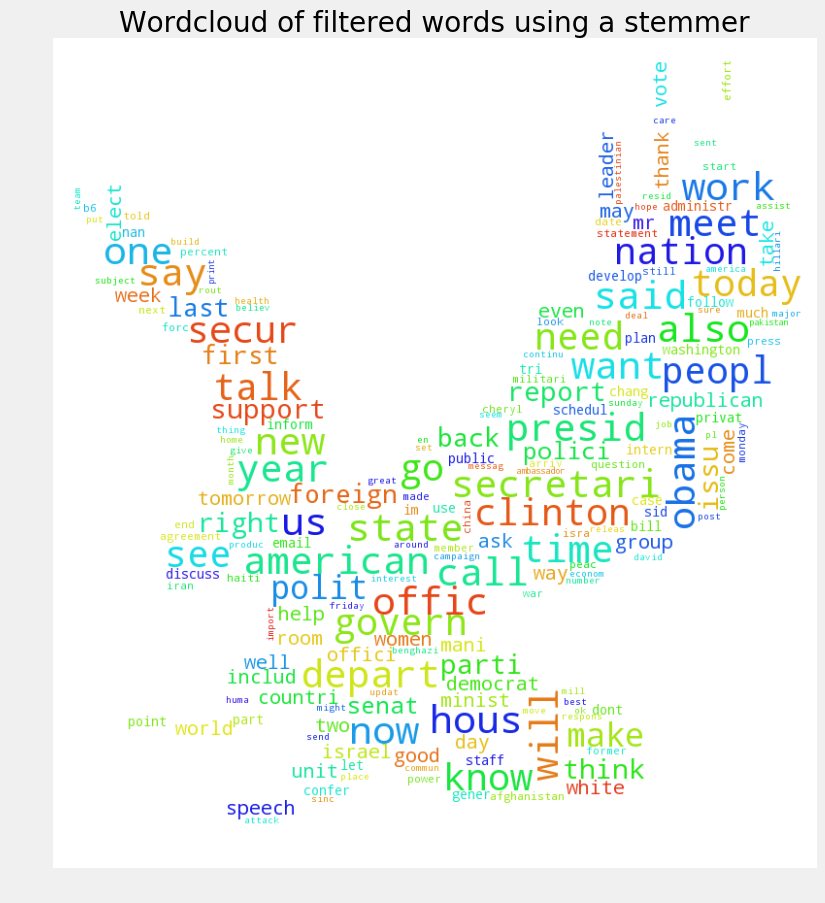

In [44]:
wordcloud = WordCloud(max_font_size=40, background_color="white", mask=mask).generate(text_processed_stem) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Wordcloud of filtered words using a stemmer")
plt.axis("off")
plt.show()

Well the good thing is there are less useless words using a stemmer, but some of the remaining words are not very pleasent : "hous", "secretari", "offic"... This is a drawback of stemming : the operation is pretty harsh and leaves some words that actually do not exist. Although we understand what it means

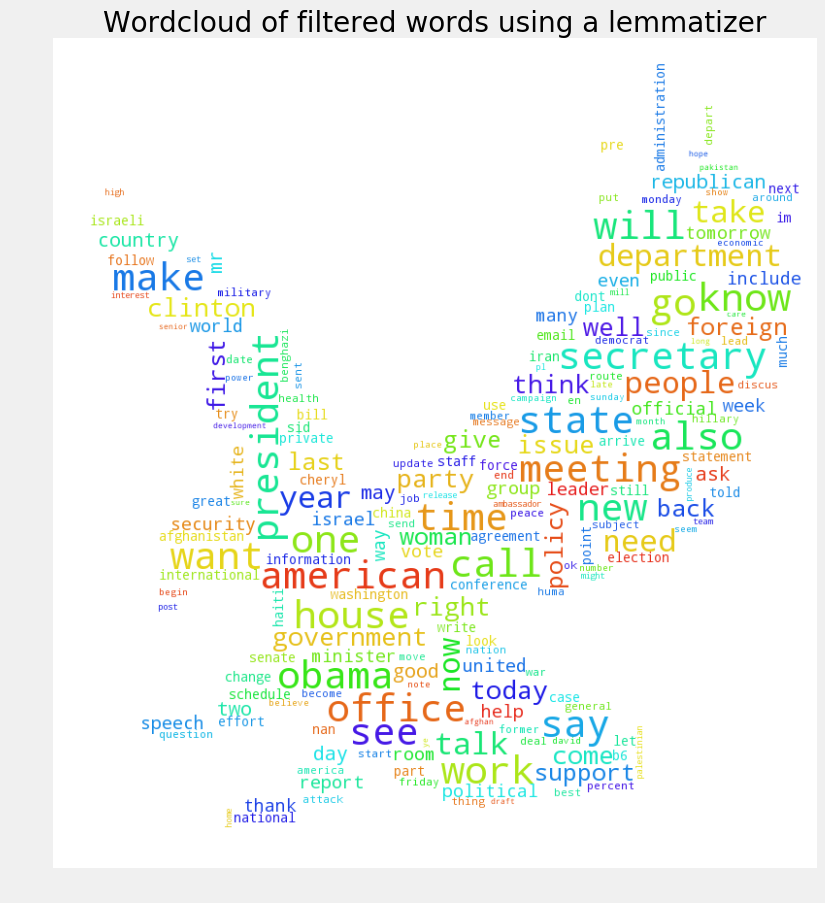

In [45]:
wordcloud = WordCloud(max_font_size=40, background_color="white", mask=mask).generate(text_processed_lemma)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Wordcloud of filtered words using a lemmatizer")
plt.axis("off")
plt.show()

Using the lemmatizer, we actually manage to find the words lemmes given their part of speech tag, and that's often very accurate and the good point is that the words all actually belong to the english language in the end! 

So at least this wordcloud is clean. Now one can always question how much information a wordcloud brings. In this case, we could argue that there's little to catch from this wordcloud, as it's a very narrow look on the whole data, and most of words could have been expected. And here, on this dataset, we really want to find unexpected things.

### Part 1 summary

Wordcloud pros :  
- very easy to do
- very talkative and fancy visualization, people can understand easily

Wordclous cons :
- narrow view of the whole data : if the goal is to find surprising things, wordclouds may not be a good tool

Best NLP pipeline with a __lemmatizer__

# 2. About Sentiment Analysis

> Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

We'll use the NLTK Vader Sentiment Analysis tools

In [50]:
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycountry
import seaborn as sns

Let's see how it works :

In [47]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores("this homework is an awesome homework")

{'compound': 0.6249, 'neg': 0.0, 'neu': 0.549, 'pos': 0.451}

We get scores for compound, negativity, neutrality and positivity. In our case, it seems to work, as the compound is strong and the positive score is pretty strong too. 

Let's apply this intensity analyzer to our corpus. One question to ask is : should we use it on the raw data or on the processed data... ? Let's start with the raw data we obtained with a lemmatizer.

In [48]:
polarity_scores = [sid.polarity_scores(t) for t in data.Lemma.values]

In [49]:
data["PositiveScore"] = [s["pos"] for s in polarity_scores]
data["NegativeScore"] = [s["neg"] for s in polarity_scores]
data["NeutralScore"] = [s["neu"] for s in polarity_scores]
data["CompoundScore"] = [s["compound"] for s in polarity_scores]

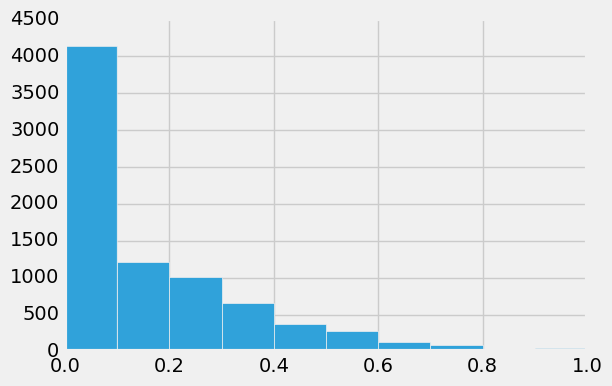

In [50]:
data.PositiveScore.hist()

What are the e-mails scored very positive ?

In [51]:
data[data.PositiveScore>=0.8].drop_duplicates().head(3)

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma,PositiveScore,NegativeScore,NeutralScore,CompoundScore
Id,,,,,,,,,
1,FW: Wow,,FW: Wow,wow,wow,1.0,0.0,0.0,0.5859
57,FW: thanks,,FW: thanks,thank,thanks,1.0,0.0,0.0,0.4404
146,FW: Thanks,,FW: Thanks,thank,thanks,1.0,0.0,0.0,0.4404


Seems to work for positive scores :) How about negative?

In [52]:
data[data.NegativeScore>0.672][["Lemma", "NegativeScore"]].head(7)

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma,PositiveScore,NegativeScore,NeutralScore,CompoundScore
Id,,,,,,,,,
349,Re:,I'll call her this am.,Re: I'll call her this am.,ill call,ill call,0.0,0.737,0.263,-0.4215
1390,FW: Dead Aid,FFYI,FW: Dead Aid FFYI,dead aid ffyi,dead aid ffyi,0.0,0.683,0.317,-0.6486
3212,Police: Bomb kills 5 in northwest Pakistan,,Police: Bomb kills 5 in northwest Pakistan,polic bomb kill 5 northwest pakistan,police bomb kill 5 northwest pakistan,0.0,0.725,0.275,-0.8360
3529,FW: Death of,FYI,FW: Death of FYI,death,death,0.0,1.000,0.000,-0.5994
3571,Fw: UPDATE: Death of,,Fw: UPDATE: Death of,updat death,update death,0.0,0.796,0.204,-0.5994
4603,IDB/Haiti Debt,,IDB/Haiti Debt,idbhaiti debt,idbhaiti debt,0.0,0.714,0.286,-0.3612
5000,Re: London,No problem,Re: London No problem,london problem,london problem,0.0,0.730,0.270,-0.4019


Here we realize it works well except for the first one : because of the NLP processing, `I'll` became `ill` which is interpreted as very negative. Which leads to a false-negative ! Let's see if we do it on the raw data

In [53]:
sid.polarity_scores("I'll call her this am.")

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

Works better... It is indeed neutral. Actually thanks to this example we realized the sentiment analysis should be kept on the raw data.  

(commented to avoid slowness)

In [54]:
#polarity_scores = [sid.polarity_scores(t) for t in data.Raw.values]

In [55]:
#data["PositiveScore"] = [s["pos"] for s in polarity_scores]
#data["NegativeScore"] = [s["neg"] for s in polarity_scores]
#data["NeutralScore"] = [s["neu"] for s in polarity_scores]
#data["CompoundScore"] = [s["compound"] for s in polarity_scores]

In [38]:
data = pd.read_csv("data.csv", index_col=0)

## 2.1 Getting the e-mails that talk about countries

Let's get the names of all the countries using `pycountry`. We remove "Jersey" to avoid conflicts with the state New Jersey

In [43]:
countries = [c.name.lower() for c in pycountry.countries if c.name.lower() != "jersey"]

In [44]:
print("There are %s countries" % len(countries))

There are 248 countries


We want to find whether these countries appear in the e-mails. So we define a function `find_countries()` to do just that :

In [45]:
def find_countries(txt):
    """ outputs countries c1,c2,.. found inside 
    a text as a string with format c1 ; c2 ;... """
    
    return ";".join([country for country in countries if country in txt.lower()])

In [46]:
data["Countries"] = data.Raw.astype(str).apply(find_countries)

In [47]:
found_countries = []
for i in data.Countries.values:
    found_countries.append(i.split(";"))
print(len(list(set([item for sublist in found_countries for item in sublist]))), "countries found in the data")

148 countries found in the data


In [48]:
temp=[]
for i, row in enumerate(data[["CompoundScore", "Countries"]].itertuples()):
    countries_found = str(row.Countries).split(";")
    for c in countries_found:
        temp.append({"CompoundScore": row.CompoundScore, "Countries": c})

In [49]:
sentiment_data = pd.DataFrame(temp)

Let's see how the countries presences are distributed in the emails

In [52]:
sentiment_data.groupby("Countries").count().head()

,CompoundScore
Countries,
,6293
afghanistan,126
albania,3
algeria,6
angola,18


So we managed to get scores for many e-mails. In total, 6500 countries occurrences were found in the e-mails. We can see it is not really equally distributed among countries only by looking the head of the dataframe : 
- afghanistan is found 126 times
- albania only 3 times...

We aggregate the compound scores for each country and take the average of it :

In [53]:
countries_sentiment = sentiment_data.groupby("Countries").CompoundScore.mean().sort_values()

In [54]:
countries_sentiment.head()

Countries
united arab emirates   -0.98640
maldives               -0.97695
guinea-bissau          -0.77170
sierra leone           -0.71180
gabon                  -0.71180
Name: CompoundScore, dtype: float64

Let's plot this using a colored bar plot. We define our color palette using `seaborn`. (from red (negative compound) to blue (good compound))

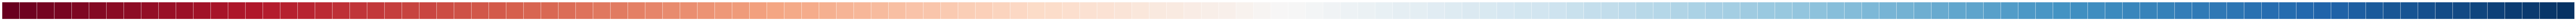

In [55]:
palette = sns.color_palette("RdBu", n_colors=len(countries_sentiment))
sns.palplot(palette)

## 2.2 Final visualizations

We have a lot of countries on the x-axis, but exporting it and opening in somewhere else makes it easier to read. Although we can already see that countries like Monaco, Luxembourg are very high-rated when Honduras or Bemuda have little reputation in Hillary's e-mails

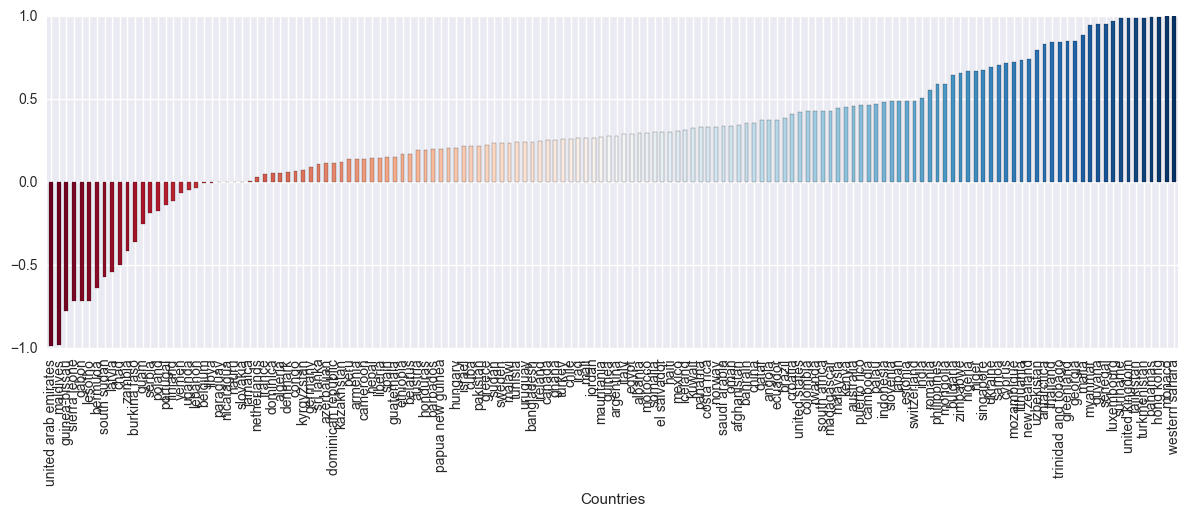

In [59]:
sns.set_context(rc = {'patch.linewidth': 0.15});
countries_sentiment.plot(kind='bar', figsize=(13,4), color= palette, edgecolor="black");

---

### Disclaimer !

We acknowledge the following limits in our pipeline : 
- didn't take into account acronyms, as a result we miss occurrences like "US"... There would still be limits using acronyms like US : the subject 'us' appears a lot in our text and it is not related to the United States. Some conflicts of that kind may appear more than we think on short words such as acronyms, may it be because they have multiple meanings, or because OCR has errors and actually output short words instead of punctuations or whatever..
- didn't either take into account nationalities/adjectives (french, swiss, american...). But one could argue that it makes sense not to count them because they do not necessarily reflect the country's vision but just a local biased vision on one individual/thing that would hardly generalize to the whole country.
- ratings can be very biased by the fact that there are in the end very few mails concerning some countries (e.g albania only 3 e-mails) : we couldn't have serious conclusions on hillary's feeling towards them. One good thing if we wanted to have serious conclusions would be to threshold and keep only countries that have had enough occurrences. Well, we're not doing politics anyway

---

### ->  Improving the unbalanced dataset bias
To overcome the second limit, let's make the visualization take into account the frequency of e-mails found with given countries names in order to have a confidence measure on the sentiment analysis

In [60]:
countries_sent = pd.DataFrame(index=countries_sentiment.index)
countries_sent["score"] = sentiment_data.groupby("Countries").CompoundScore.mean()
countries_sent["count_"] = sentiment_data.groupby("Countries").CompoundScore.count()

In [61]:
countries_sent = countries_sent[countries_sent.index != ""]

In [62]:
def plot_histogram_sentiment(df, size):
    """ plots a histogram with sentiment analysis, credits to Maxime Peschard """
    # Credits to Stack Overflow :
    # http://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value
    from matplotlib import cm

    plt.figure(num=None, figsize=size, dpi=80, facecolor='w', edgecolor='k')
    # Set up colors : red to green
    y = np.array(df['score'])
    colors = cm.RdYlGn(y / float(max(y)))
    plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
    plt.clf()
    clb = plt.colorbar(plot)
    clb.ax.set_title("Sentiment")

    # Display bar plot : country frequency vs. country name, with color indicating polarity score
    plt.bar(range(df.shape[0]), countries_sent['count_'], 
            align='center', tick_label=df.index, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Country")
    plt.ylabel("Frequency")
    plt.show()

Keeping all countries, it is hard to read anything. We'll only display countries that appear at leats 10 times in the dataset

In [66]:
COUNT_THRESHOLD = 10

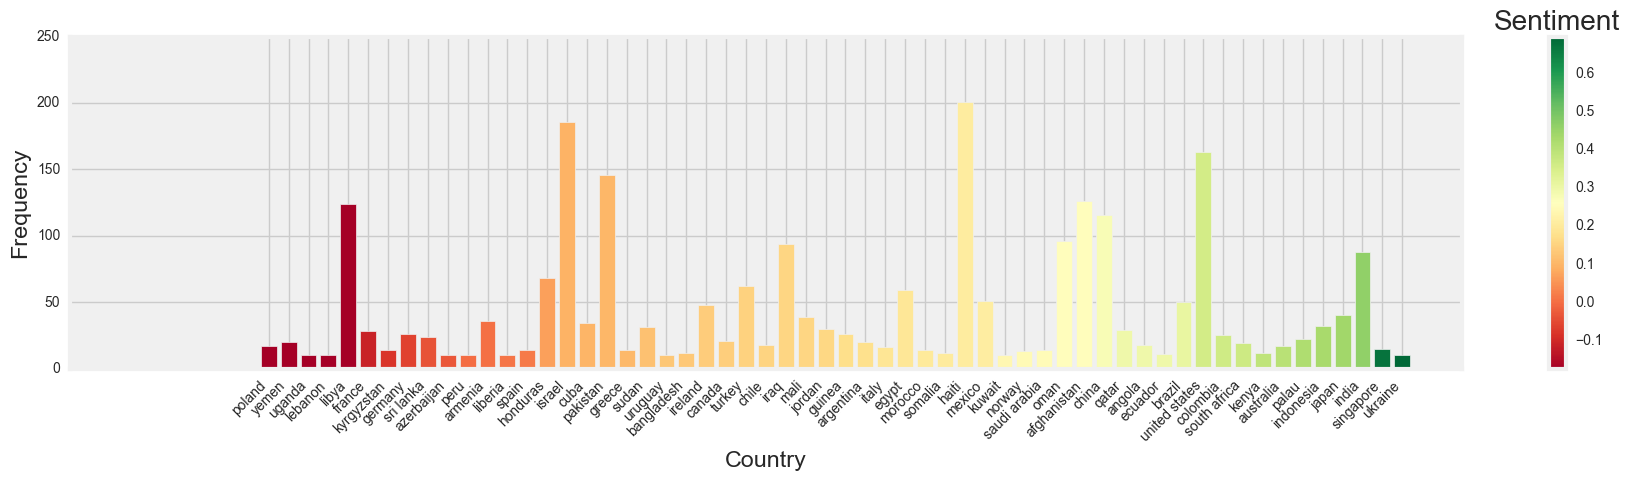

In [67]:
countries_sent = countries_sent[countries_sent.count_ >= COUNT_THRESHOLD]
plot_histogram_sentiment(countries_sent, (20,4))

Now this visualization makes sense! Displays only countries where we have a minimum confidence interval (because more than 10 samples), and turns out that Libya has a very strong confidence with negative sentiment, which makes total sense... Weird for Poland ? 

In [226]:
print(data.set_index("Countries").loc["poland"].Raw.values[1])
print(data.set_index("Countries").loc["poland"].Raw.values[3])
print(data.set_index("Countries").loc["poland"].Raw.values[4])

Fw: (AP) Top Russian official: no missiles near Poland  
Albright Call with Otunbayeva Fyi -- not sure of timing of your call.
Terrible news about Poland.
I'm on the ground and reachable at your convenience.
  U ok with statement?
Statement by the Secretary
The Death of Polish President Kaczynski and His Delegation
I join President Obama in offering my deepest condolences to the people of Poland, to the Kaczynski family, and to the
families of all those killed in this tragedy. Lost alongside President Kaczynski and his wife were Polish leaders from
across the political spectrum, men and women who shaped and sped Poland's post-1989 democratic transformation and
were leading Poland into its promising future. The tragedy of these lives cut short will be felt deeply across the world,
but their legacy will live on in a free and flourishing Poland.
The United States stands with the Polish people in this difficult hour. Like the country he led, President Kaczynski was
one of America's most va

That's because of the plane accident with Polish delegation...

# 3. Topic extraction

> Using the models.ldamodel module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.

In [7]:
from gensim.models import LdaModel
from gensim import corpora
import logging
#logging.basicConfig(format='%(message)s', level=logging.INFO)
logging.getLogger("gensim").setLevel(logging.WARNING)

In [8]:
data.Lemma = data.Lemma.astype(str)

In [9]:
# define a term-document matrix
final_text = [t.split(" ") for t in data.Lemma.values]
dictionary = corpora.Dictionary(final_text)
corpus = [dictionary.doc2bow(text) for text in final_text]

We run LDA model using e-mails as documents, for example for 3 topics we would run it like that. Passing 5 times enable to have more precise results.

In [16]:
# run model
lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=5)

## 3.1 Manual evaluation of topics extraction

Well we are looking for a human-intelligible result so it makes sense to look manually a little at the topics distrubution over words, and see if they highlight some real semantic cluster. 

An interesting way to look at the extracted topics and which words lie inside is to use the library `pyLDAvis` (see below).   
We'll see topic extraction for respectively 3, 8, 15, 30 and 50 topics. 

__NOTE :__ We'll always consider the visualization for the relevance metric $\lambda =0$ (use slider) in order to remove too frequent words that remained even after filtering stop words.

In [30]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#### For 3 topics

In [32]:
n_topics = 3
lda3 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda3, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      43.654483        1       1 -0.121964 -0.079562
2      36.818566        1       2 -0.095016  0.086434
0      19.526951        1       3  0.216980 -0.006872, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
24745  Default  1967.000000        call  1967.000000  30.0000  30.0000
24469  Default  1359.000000   secretary  1359.000000  29.0000  29.0000
1428   Default  1127.000000      office  1127.000000  28.0000  28.0000
12795  Default   911.000000           h   911.000000  27.0000  27.0000
25910  Default   872.000000     meeting   872.000000  26.0000  26.0000
3483   Default  1036.000000        2010  1036.000000  25.0000  25.0000
16381  Default   575.000000           2   575.000000  24.0000  24.0000
7017   Default  1926.000000       state  1926.000000  23.0000  23.0000
11412  Default   466.000000        room   466.000000  22.0000  22.0000
19518  Default   575.000000           1   575.000000  21.0000  21.0000
4606   Default   709.000000  department   709.000000  20.0000  20.0000
13441  Default   324.000000      cheryl   324.000000  19.0000  19.0000
21566  Default   334.000000          b6   334.000000  18.0000  18.0000
15457  Default   291.000000          en   291.000000  17.0000  17.0000
21526  Default   305.000000          ok   305.000000  16.0000  16.0000
12118  Default   294.000000       route   294.000000  15.0000  15.0000
2363   Default   322.000000      arrive   322.000000  14.0000  14.0000
8609   Default   372.000000    schedule   372.000000  13.0000  13.0000
16137  Default   583.000000        2009   583.000000  12.0000  12.0000
3849   Default   284.000000      depart   284.000000  11.0000  11.0000
6597   Default   273.000000        huma   273.000000  10.0000  10.0000
24562  Default   619.000000  republican   619.000000   9.0000   9.0000
17079  Default   265.000000         pls   265.000000   8.0000   8.0000
13106  Default   493.000000           w   493.000000   7.0000   7.0000
683    Default   386.000000           3   386.000000   6.0000   6.0000
24712  Default   603.000000      israel   603.000000   5.0000   5.0000
16524  Default   241.000000        mill   241.000000   4.0000   4.0000
18477  Default   475.000000    tomorrow   475.000000   3.0000   3.0000
23497  Default   224.000000   residence   224.000000   2.0000   2.0000
16685  Default  2021.000000         say  2021.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
21566   Topic3   307.668597          b6   334.350956   1.5502  -5.4665
3475    Topic3   137.593696       jacob   144.940417   1.5814  -6.2713
2363    Topic3   293.449806      arrive   322.675340   1.5384  -5.5139
1428    Topic3   915.450414      office  1127.439570   1.4251  -4.3761
11412   Topic3   406.092483        room   466.347540   1.4950  -5.1890
6700    Topic3   210.257681           d   229.593991   1.5454  -5.8472
10715   Topic3   158.912122         ops   170.310275   1.5641  -6.1272
12618   Topic3   130.422185           t   137.468358   1.5808  -6.3248
12795   Topic3   711.109279           h   911.416941   1.3852  -4.6287
24469   Topic3   991.161834   secretary  1359.250872   1.3176  -4.2967
24745   Topic3  1343.467295        call  1967.196876   1.2520  -3.9926
16381   Topic3   456.766858           2   575.237737   1.4028  -5.0714
8609    Topic3   303.041070    schedule   372.916712   1.4259  -5.4817
19518   Topic3   430.135939           1   575.638449   1.3420  -5.1315
25910   Topic3   590.576177     meeting   872.399792   1.2432  -4.8145
683     Topic3   298.416423           3   386.388514   1.3750  -5.4971
3483    Topic3   601.867086        2010  1036.988185   1.0893  -4.7955
12343   Topic3   197.764324       print   242.411336   1.4298  -5.9085
16137   Topic3   355.146558        2009   583.813199   1.1363  -5.

Topic 1 seems to talk about military-related subjects (afghan, arab, nuclear, gaza, mcchrystal...) , while topic 2 is more about politics (tax, labor, amendment, lobbyist...) and topic 3 is a trash topic with e-mails and numbers. So we can say the topic extraction is not bad.

#### For 8 topics

In [33]:
n_topics = 8
lda8 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda8, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      36.844325        1       1  0.141584 -0.032238
3      19.695349        1       2  0.160542 -0.040518
2      12.742129        1       3  0.015566  0.239000
6       9.491589        1       4  0.149861 -0.159585
1       7.111629        1       5 -0.269037 -0.062229
5       6.463823        1       6 -0.061107  0.061262
0       3.948632        1       7  0.033171  0.084885
7       3.702525        1       8 -0.170580 -0.090575, topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
24469  Default  1360.000000     secretary  1360.000000  30.0000  30.0000
7017   Default  1969.000000         state  1969.000000  29.0000  29.0000
24745  Default  1944.000000          call  1944.000000  28.0000  28.0000
1428   Default  1129.000000        office  1129.000000  27.0000  27.0000
2802   Default  2571.000000          will  2571.000000  26.0000  26.0000
23552  Default  1476.000000           can  1476.000000  25.0000  25.0000
4606   Default   730.000000    department   730.000000  24.0000  24.0000
25910  Default   872.000000       meeting   872.000000  23.0000  23.0000
16219  Default  1996.000000             u  1996.000000  22.0000  22.0000
3483   Default   999.000000          2010   999.000000  21.0000  21.0000
16381  Default   524.000000             2   524.000000  20.0000  20.0000
12795  Default   877.000000             h   877.000000  19.0000  19.0000
19518  Default   523.000000             1   523.000000  18.0000  18.0000
11412  Default   472.000000          room   472.000000  17.0000  17.0000
641    Default   793.000000             —   793.000000  16.0000  16.0000
19864  Default  1146.000000           get  1146.000000  15.0000  15.0000
21236  Default   814.000000         house   814.000000  14.0000  14.0000
25654  Default   375.000000          case   375.000000  13.0000  13.0000
5869   Default   828.000000          talk   828.000000  12.0000  12.0000
2363   Default   323.000000        arrive   323.000000  11.0000  11.0000
18477  Default   480.000000      tomorrow   480.000000  10.0000  10.0000
15457  Default   291.000000            en   291.000000   9.0000   9.0000
12118  Default   294.000000         route   294.000000   8.0000   8.0000
683    Default   353.000000             3   353.000000   7.0000   7.0000
3849   Default   284.000000        depart   284.000000   6.0000   6.0000
13127  Default   296.000000     agreement   296.000000   5.0000   5.0000
312    Default  1194.000000          work  1194.000000   4.0000   4.0000
2061   Default   407.000000         email   407.000000   3.0000   3.0000
17573  Default   358.000000       private   358.000000   2.0000   2.0000
14737  Default   253.000000   information   253.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
3359    Topic8    20.566979  subsequently    21.392724   3.2568  -6.5091
3667    Topic8    18.887583           2pm    19.648202   3.2567  -6.5943
15097   Topic8   127.086105          dept   132.316550   3.2558  -4.6879
825     Topic8    18.111369           inr    18.874373   3.2549  -6.6362
18181   Topic8    19.002980          b5b6    19.823056   3.2539  -6.5882
16122   Topic8    17.451456           dep    18.210745   3.2536  -6.6734
12376   Topic8    17.579094          lear    18.348250   3.2533  -6.6661
12178   Topic8    55.558535        libyan    58.189042   3.2499  -5.5153
2978    Topic8    15.464413     c05739767    16.223755   3.2482  -6.7942
12312   Topic8    18.855343    impression    19.842547   3.2451  -6.5960
12382   Topic8    42.096508       verveer    45.753690   3.2128  -5.7928
28063   Topic8   122.838467     sensitive   140.427302   3.1623  -4.7219
22831   Topic8   116.252373        select   132.758876   3.1634  -4.7770
5901    Topic8    22.149652       morocco    23.456447   3.

Topic 1 is clearly about war  
Topic 4 about personalities.   
Other topics make no real sense..

#### For 15 topics

In [34]:
n_topics = 15
lda15 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda15, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      33.393479        1       1  0.205648 -0.012557
8      10.337494        1       2  0.059599 -0.266131
11      9.932427        1       3  0.163203  0.094064
13      9.597783        1       4  0.186798 -0.013638
9       5.877170        1       5 -0.113643  0.061153
10      4.464536        1       6  0.105241  0.043825
6       4.196531        1       7 -0.088013  0.070753
0       4.083331        1       8 -0.199766 -0.172181
4       3.687412        1       9  0.069468  0.117044
12      3.647342        1      10 -0.044838  0.065475
1       3.158939        1      11 -0.035208 -0.045025
2       2.516157        1      12  0.046717 -0.059196
7       2.406742        1      13 -0.054583 -0.107750
3       1.731596        1      14 -0.115705  0.164194
14      0.969062        1      15 -0.184918  0.059972, topic_info=      Category         Freq                  Term        Total  loglift  \
term                                                                      
1428   Default  1148.000000                office  1148.000000  30.0000   
24469  Default  1375.000000             secretary  1375.000000  29.0000   
24745  Default  1985.000000                  call  1985.000000  28.0000   
7017   Default  2024.000000                 state  2024.000000  27.0000   
12795  Default   876.000000                     h   876.000000  26.0000   
3483   Default  1000.000000                  2010  1000.000000  25.0000   
2802   Default  2601.000000                  will  2601.000000  24.0000   
23552  Default  1507.000000                   can  1507.000000  23.0000   
25232  Default   594.000000                     •   594.000000  22.0000   
25910  Default   879.000000               meeting   879.000000  21.0000   
641    Default   786.000000                     —   786.000000  20.0000   
4606   Default   754.000000            department   754.000000  19.0000   
950    Default   270.000000                   nan   270.000000  18.0000   
16381  Default   525.000000                     2   525.000000  17.0000   
16219  Default  2033.000000                     u  2033.000000  16.0000   
11412  Default   477.000000                  room   477.000000  15.0000   
25123  Default   587.000000                    mr   587.000000  14.0000   
19518  Default   519.000000                     1   519.000000  13.0000   
16685  Default  2025.000000                   say  2025.000000  12.0000   
24562  Default   595.000000            republican   595.000000  11.0000   
25091  Default   739.000000                 party   739.000000  10.0000   
19864  Default  1153.000000                   get  1153.000000   9.0000   
5869   Default   842.000000                  talk   842.000000   8.0000   
18477  Default   492.000000              tomorrow   492.000000   7.0000   
16137  Default   553.000000                  2009   553.000000   6.0000   
2363   Default   330.000000                arrive   330.000000   5.0000   
25245  Default   223.000000                  koch   223.000000   4.0000   
25629  Default   298.000000                update   298.000000   3.0000   
24762  Default   446.000000                  vote   446.000000   2.0000   
12118  Default   300.000000                 route   300.000000   1.0000   
...        ...          ...                   ...          ...      ...   
16415  Topic15     7.333874                 amcit     8.197779   4.5252   
23460  Topic15     6.985346             feinstein     7.815722   4.5243   
19633  Topic15     6.908101        discrimination     7.737799   4.5232   
2805   Topic15     6.743908                    vm     7.574085   4.5205   
26198  Topic15     6.746647                allawi     7.603982   4.5170   
166    Topic15     6.121181  valenzuelaaastategov     6.951504   4.5094   
293    Topic15     5.605104            philippine     6.444412   4.4971   
16457  Topic15    11.185726            

Topic 1 : economy,  
topic 3 : politics,  
topic 8 : e-mail related fields,  
topic 9 : war.  
All others are trash topics

#### For 30 topics

In [35]:
n_topics = 30
lda30 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda30, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      18.153764        1       1  0.265949 -0.052001
14     15.308458        1       2  0.267658 -0.074863
25      9.904514        1       3  0.226325 -0.132933
7       6.844521        1       4  0.219128  0.146100
3       6.451962        1       5  0.223497 -0.102667
28      4.630423        1       6  0.096225 -0.099803
26      4.433589        1       7  0.147091  0.233959
27      4.423600        1       8 -0.043009  0.113794
2       4.352339        1       9 -0.001255 -0.134098
13      3.264955        1      10  0.139097  0.231228
11      3.093812        1      11  0.091248 -0.154203
8       2.357196        1      12  0.087577 -0.022222
15      1.916107        1      13 -0.112359 -0.062337
5       1.623990        1      14 -0.058606  0.137982
1       1.317694        1      15  0.013621  0.075157
23      1.277463        1      16  0.041161 -0.017675
17      1.174408        1      17 -0.080453  0.086081
24      0.987536        1      18 -0.071419 -0.052307
22      0.914369        1      19 -0.058086  0.070366
10      0.836538        1      20 -0.097435  0.036184
9       0.781113        1      21 -0.141214 -0.107291
18      0.759105        1      22 -0.122182 -0.006408
21      0.759052        1      23 -0.130334 -0.064598
29      0.750092        1      24 -0.128723 -0.041118
12      0.707467        1      25 -0.104169  0.042088
0       0.667847        1      26 -0.128011  0.009786
6       0.666533        1      27 -0.156685 -0.003746
20      0.555343        1      28 -0.139846 -0.005726
19      0.553068        1      29 -0.106420 -0.059345
16      0.533141        1      30 -0.138371  0.010617, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
24745  Default  1950.000000                call  1950.000000  30.0000  30.0000
7017   Default  2024.000000               state  2024.000000  29.0000  29.0000
24469  Default  1378.000000           secretary  1378.000000  28.0000  28.0000
1428   Default  1146.000000              office  1146.000000  27.0000  27.0000
2802   Default  2560.000000                will  2560.000000  26.0000  26.0000
25232  Default   650.000000                   •   650.000000  25.0000  25.0000
12795  Default   903.000000                   h   903.000000  24.0000  24.0000
3483   Default  1042.000000                2010  1042.000000  23.0000  23.0000
23552  Default  1487.000000                 can  1487.000000  22.0000  22.0000
16219  Default  2022.000000                   u  2022.000000  21.0000  21.0000
24712  Default   522.000000              israel   522.000000  20.0000  20.0000
24562  Default   590.000000          republican   590.000000  19.0000  19.0000
4606   Default   768.000000          department   768.000000  18.0000  18.0000
25091  Default   728.000000               party   728.000000  17.0000  17.0000
14297  Default   657.000000               woman   657.000000  16.0000  16.0000
28369  Default   485.000000              speech   485.000000  15.0000  15.0000
5869   Default   836.000000                talk   836.000000  14.0000  14.0000
25910  Default   897.000000             meeting   897.000000  13.0000  13.0000
21236  Default   858.000000               house   858.000000  12.0000  12.0000
768    Default   401.000000                 sid   401.000000  11.0000  11.0000
12905  Default   380.000000             israeli   380.000000  10.0000  10.0000
11412  Default   485.000000                room   485.000000   9.0000   9.0000
16381  Default   583.000000                   2   583.000000   8.0000   8.0000
13106  Default   523.000000                   w   523.000000   7.0000   7.0000
950    Default   395.000000                 nan   395.000000   6.0000   6.0000
25123  Default   607.000000                  mr   607.000000   5.0000   5.0000
19864  Default  1

Topic 1 : politics (economy)  
Topic 2 : religion (religion, mariage, faith, christian...)  
Topic 6 : personalities  
Topic 8 : emails  
Topic 11 : israel palestine conflict !!  
Topic 17 : mobile email   
Topics 22, 23, 24, 27: personalities  

#### For 50 topics

In [37]:
n_topics = 50
lda50 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda50, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
32     13.608398        1       1 -0.260938 -0.009387
41     12.105849        1       2 -0.253494  0.000842
47      8.525615        1       3 -0.298886  0.007954
48      4.649859        1       4 -0.197484 -0.082667
13      4.407995        1       5 -0.245090 -0.015017
43      4.209724        1       6 -0.130295  0.224631
21      3.922252        1       7 -0.244746 -0.049690
9       3.559562        1       8 -0.189703 -0.100494
42      3.544019        1       9 -0.023985 -0.233786
10      3.035125        1      10 -0.183790 -0.064684
11      2.792785        1      11 -0.094450  0.257774
24      2.623337        1      12 -0.147906 -0.094096
16      2.599083        1      13  0.030027 -0.013366
36      1.945998        1      14 -0.096761  0.020346
29      1.905554        1      15  0.035229 -0.217389
26      1.426326        1      16  0.107290  0.090026
7       1.319641        1      17  0.086275 -0.120731
6       1.214380        1      18 -0.073129  0.032085
28      1.150178        1      19 -0.041006 -0.029756
30      1.135747        1      20 -0.051322  0.059315
8       1.080456        1      21 -0.037977 -0.043439
45      1.059624        1      22  0.007813  0.143143
1       0.955770        1      23 -0.021462  0.152585
37      0.947336        1      24 -0.028007 -0.014118
40      0.889348        1      25  0.094680 -0.045214
35      0.865329        1      26  0.014500  0.017343
23      0.863929        1      27  0.023230  0.062751
4       0.812862        1      28  0.046822  0.010260
15      0.804826        1      29  0.103083  0.041150
20      0.797177        1      30 -0.002555 -0.039998
46      0.745354        1      31  0.120691 -0.048011
33      0.733676        1      32  0.151697  0.028755
27      0.722713        1      33  0.097944  0.008432
19      0.695795        1      34  0.052779  0.037760
3       0.688579        1      35  0.114766  0.064100
49      0.674615        1      36  0.059143  0.078947
5       0.669752        1      37  0.078962  0.061701
18      0.665706        1      38  0.026553  0.031307
39      0.654041        1      39  0.075160 -0.081752
2       0.598930        1      40  0.037468  0.102729
12      0.598515        1      41  0.127764 -0.033851
34      0.567533        1      42  0.082760 -0.060447
17      0.560785        1      43  0.094771  0.043852
25      0.505383        1      44  0.121246  0.018444
0       0.447324        1      45  0.130517  0.018996
44      0.420402        1      46  0.098842  0.006046
31      0.365906        1      47  0.136893 -0.094872
22      0.350276        1      48  0.164272 -0.029780
14      0.330737        1      49  0.131652 -0.042715
38      0.245892        1      50  0.170162 -0.056016, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
24745  Default  2005.000000        call  2005.000000  30.0000  30.0000
24469  Default  1451.000000   secretary  1451.000000  29.0000  29.0000
25232  Default   630.000000           •   630.000000  28.0000  28.0000
1428   Default  1206.000000      office  1206.000000  27.0000  27.0000
3483   Default  1055.000000        2010  1055.000000  26.0000  26.0000
12795  Default   937.000000           h   937.000000  25.0000  25.0000
2802   Default  2599.000000        will  2599.000000  24.0000  24.0000
7017   Default  2070.000000       state  2070.000000  23.0000  23.0000
23552  Default  1499.000000         can  1499.000000  22.0000  22.0000
19864  Default  1146.000000         get  1146.000000  21.0000  21.0000
16381  Default   533.000000           2   533.000000  20.0000  20.0000
23018  Default   700.000000     clinton   700.000000  19.0000  19.0000
19518  Default   542.000000           1   542.000000  18.0000  18.0000
16685  Default  2072.000000         say  2072.000000  17.0000  17.0000
24712  Defaul

Topic 4 : israel / palestine  
Topic 10 : economy   
Topic 12 : politics  
Topic 13 : numbers  
Topic 15 : airports  
Topic 17 : personalities    
Topic 21 : personalitites  
Topic 31 : personalities  
Topic 38 : taliban, al qaida  
Rest is either trash topics, or we don't really understand what it talks about...




__Conclusion :__ When growing the number of topics, we manage to get more interesting topics but the proportion of valid over trash topics goes down. For 50 topics, only 8 made sense for us, but for 15 topics, 4 made sense. Moreover, when number of topics grow, the scope they represent gets narrow and narrow and it really requires field knowledge to find links (some topics we don't really know any of the words...).

## 3.2 Using likelihoods

We can evaluate the topic extraction performance using LDA's log likelihood. In fact, `gensim` provides a similar measure called `perplexity`. By browsing online, we've found a few similar definitions of this perplexity and how to measure it, we first want to compare these measures in order to see if they have the same insight. We'll namely compare perplexity, perplexity per word and log perplexity.

In [237]:
import random, gensim

We just need to do a test/train corpus in order to compute the likelihoods

In [ ]:
# shuffle corpus
cp = list(corpus)
random.shuffle(cp)

# split into 80% training and 20% test sets
p = int(len(cp) * .8)
cp_train = cp[0:p]
cp_test = cp[p:]

# initialize the dictionary to store results
topics_perplexity = dict()

Now let's fill in our results table with perplexity measures for a few different number of topics

In [242]:
RANGE_TOPICS=[2,5,10,20,30]

In [297]:
for n_topics in RANGE_TOPICS:
    topics_perplexity[n_topics]=dict()
    lda = gensim.models.ldamodel.LdaModel(corpus=cp_train, id2word=dictionary, num_topics=n_topics,
                                          update_every=1, chunksize=1000, passes=2)

    perplex = lda.bound(cp_test)
    topics_perplexity[n_topics]["perplexity"]=perplex

    pw_perplex = np.exp2(-perplex / sum(cnt for document in cp_test for _, cnt in document))
    topics_perplexity[n_topics]["per-word perplexity"]=pw_perplex
    
    log_perplex = lda.log_perplexity(cp_test)
    topics_perplexity[n_topics]["log perplexity"] = log_perplex

We store this in a dataframe

In [299]:
perplexities = pd.DataFrame(topics_perplexity).transpose()
perplexities

,log perplexity,per-word perplexity,perplexity
2,-13.029452,8360.954961,-846966.498864
5,-13.102960,8798.090966,-851745.774059
10,-13.502209,11602.947922,-877697.254003
20,-14.119634,17802.136211,-917841.057857
30,-14.780133,28126.521459,-960735.947263


How do these measures compare themselves ?

In [300]:
res.corr()

,log perplexity,per-word perplexity,perplexity
log perplexity,1.000000,-0.999870,0.999999
per-word perplexity,-0.999870,1.000000,-0.999881
perplexity,0.999999,-0.999881,1.000000


Ok their correlation is almost 1 or -1. So evaluating only one of them is enough, let's keep the log-perplexity and see how it evolves for a wider range of topic values on our corpus

In [314]:
RANGE_TOPICS=[2,5,10,20,40,50,80,100,120]
topics_perplexity=dict()
for n_topics in RANGE_TOPICS:
    topics_perplexity[n_topics]=dict()
    lda = gensim.models.ldamodel.LdaModel(corpus=cp_train, id2word=dictionary, num_topics=n_topics,
                                          update_every=1, chunksize=1000, passes=2)
    
    log_perplex = lda.log_perplexity(cp_test)
    topics_perplexity[n_topics]["log perplexity"] = log_perplex

Store this again in a DataFrame

In [315]:
perplexities = pd.DataFrame(topics_perplexity).transpose()

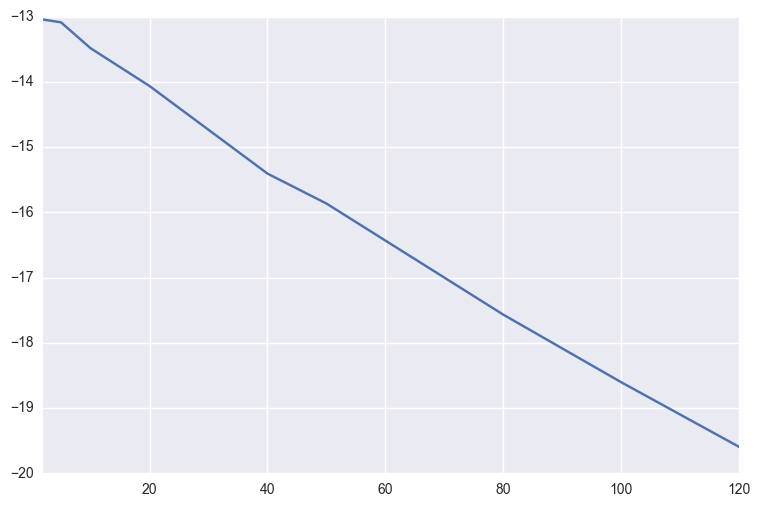

In [316]:
perplexities["log perplexity"].plot()

This measure given by gensim doesn't seem to help us at all because it almost linearly decreases with number of topics...

# Bonus : NetworkX Graph

> BONUS: build the communication graph (unweighted and undirected) among the different email senders and recipients using the NetworkX library. Find communities in this graph with community.best_partition(G) method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

We'll first import the necessary packages

In [78]:
import networkx as nx
import community

In [79]:
G=nx.Graph()

Defining edges

In [81]:
edges_df = pd.read_csv("hillary-clinton-emails/Emails.csv")[["Id","MetadataFrom", "MetadataTo"]].set_index("Id")
edges = [tuple(e) for e in edges_df.to_records(index=False)]

Defining nodes

In [82]:
nodes = list(set([item for sublist in edges for item in sublist]))

Feed the graph

In [83]:
G.add_nodes_from(nodes)
G.add_edges_from(edges)

Find the communities

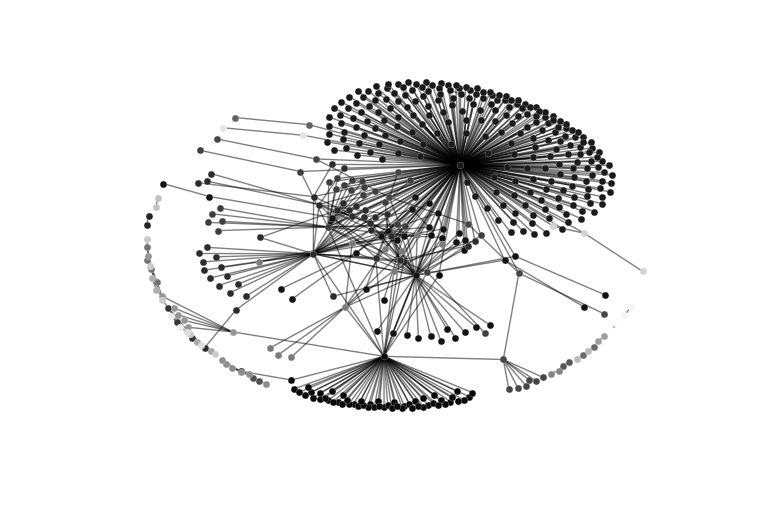

In [84]:
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)

for count, com in enumerate(set(partition.values())) :  # iterate over communities
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 25,
                                node_color = str((count+1) / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.axis('off')
plt.show()

We can see there are 3 or 4 main communities, the rest is "spread everywhere". That highlights a few nodes (politicians probably) that are in the middle of a lot of connections

Let's see the repartition of communities

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122093b38>]], dtype=object)

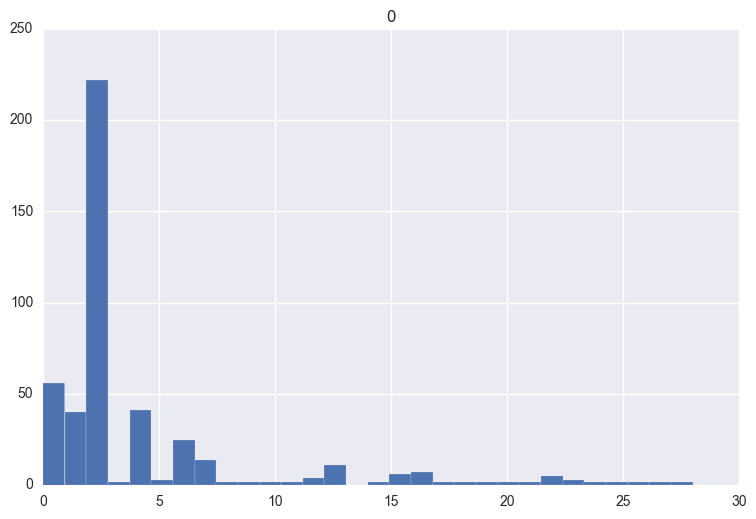

In [85]:
pd.DataFrame(list(partition.values())).hist(bins=30)

Most are in the community called "2" by our algorithm



> Print the most frequent 20 words used by the email authors of each community

We do so building a function `get_top_20_frequent_word()`

In [86]:
data = pd.read_csv("data.csv", index_col=0)[["Lemma"]]
data = data.join(edges_df)

In [92]:
data = data.reset_index()

In [203]:
def get_top_20_frequent_words(txt):
    """ from a string, returns the 20 most frequent words """
    import operator
    wordcount = [txt.count(w) for w in txt.split()] 
    wordcount_pair = dict(set(zip(txt.split(), wordcount)))
    sorted_pair = sorted(wordcount_pair.items(), key=operator.itemgetter(1))[::-1]
    return [w for w,_ in sorted_pair if len(w)>3][:20]

Now let's print these words for all communities emails

In [208]:
for com in set(partition.values()) :  # iterate over communities
    community_full = ""
    list_authors = list(set([nodes for nodes in partition.keys() if partition[nodes] == com]))
    print("\n-- Community ", com, "--\n")
    for author in list_authors:  # iterate over authors of that community
        try:
            author_txt = " ".join(data.set_index("MetadataFrom").loc[author].Lemma.values)  # get all the emails
            community_full += author_txt
        except:
            pass       
    print(" ".join(get_top_20_frequent_words(community_full)))


-- Community  0 --



-- Community  1 --

state will comm part pres side call house work make nation resident clinton president form mini just come afghan ally

-- Community  2 --

tate oman state woman will part port pres afgh work afghan side rate thank time comm call form nation eric

-- Community  3 --



-- Community  4 --

state will part secretary port work conf comm side assist depart nation time ally ecial ting schedule 2010 valmoro office

-- Community  5 --



-- Community  6 --

call will state need want 2009 deliver mail email speech cheryl sent list discus work blackberry conf also just mill

-- Community  7 --

clinton state will side part secret secretary obama policy president come mess email talk first pakistan jake form administration israel

-- Community  8 --



-- Community  9 --



-- Community  10 --

crowley philip statement jackson email agree reines exchange cheryl jeff public editorial will secretary issue madame unclassified discussion egyptian mill

-- Co

> Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

Using the graph analysis, we have __10 main communities__ that get detected. When displaying the most occurrent words within these communities emails, we can see that they are not the same between communities but that __doesn't enable us to highlight topics as LDA did in the last part.__